# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import cv2
import copy

# Racetrack environment

total reward -1239


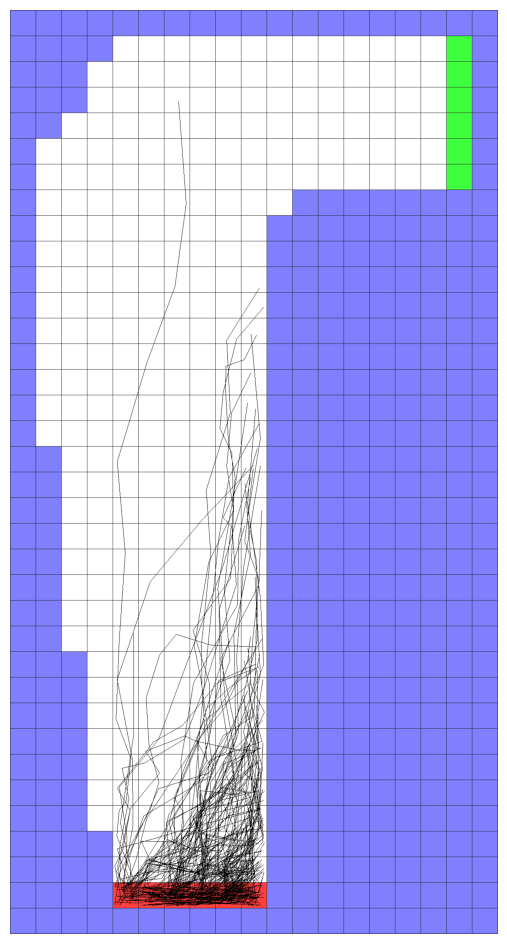

In [2]:
State = namedtuple('State', 'pos_row pos_col vel_row vel_col')

class Racetrack:
    def __init__(self, mode, max_velocity=5):
        self.OFFGRID = -1
        self.ROAD = 0
        self.START = 1
        self.FINISH = 2
        self.MAX_VELOCITY = max_velocity

        if mode == 'easy':
            board = -np.ones((10, 10))
            board[2:-2, 1:-1] = self.ROAD
            board[-2, 1:-1] = self.START
            board[1, 1:-1] = self.FINISH

        elif mode in ['hard', 'medium']:
            board = -np.ones((36, 19))
            for ri, (start, length) in enumerate(
                    [(4, 13), (3, 14), (3, 14), (2, 15), (1, 16), (1, 16), (1, 10)] +
                    [(1, 9) for _ in range(9)] +
                    [(2, 8) for _ in range(8)] +
                    [(3, 7) for _ in range(7)] +
                    [(4, 6), (4, 6)]):
                board[ri + 1, start : start + length] = self.ROAD
            board[-2, 4:10] = self.START
            board[1:7, 17] = self.FINISH
            if mode == 'medium':
                board = np.vstack([board[:10, :], board[-5:, :]])

        else:
            raise Exception(f"Unknown mode `{mode}`")

        self.board = board
        self.start_positions = []
        for r, c in np.ndindex(board.shape):
            if board[r, c] == self.START:
                self.start_positions.append((r, c))

    def render(self, runs):
        """
        Show image with board and run trajectory (if present)
        runs - array of runs
        state - tuple (pos_row, pos_col, velocity_row, velocity_col)
        """

        board = self.board
        N, M = board.shape
        CELL_SIZE = 64

        img = np.ones((N * CELL_SIZE + 1, M * CELL_SIZE + 1, 3), dtype=np.uint8) * 32

        for r, c in np.ndindex(board.shape):
            colors = {
                self.OFFGRID: [128, 128, 255],
                self.ROAD: [255, 255, 255],
                self.START: [255, 64, 64],
                self.FINISH: [64, 255, 64],
            }
            img[r * CELL_SIZE + 1 : (r + 1) * CELL_SIZE, c * CELL_SIZE + 1 : (c + 1) * CELL_SIZE, :] = colors[board[r, c]]

        for run in runs:
            sar_array = run.sar_array

            shakes = np.random.randint(5, CELL_SIZE - 5, size=((len(sar_array) + 2) // 3, 2))

            for si in range(3, len(sar_array), 3):
                prev_pos_row, prev_pos_col = sar_array[si - 3].pos_row, sar_array[si - 3].pos_col
                pos_row, pos_col = sar_array[si].pos_row, sar_array[si].pos_col

                is_reset = 0 <= prev_pos_row < N and 0 <= prev_pos_col < M and 0 <= pos_row < N and 0 <= pos_col < M and (board[prev_pos_row, prev_pos_col] != self.START) and board[pos_row, pos_col] == self.START

                if not is_reset:
                    x1 = prev_pos_col * CELL_SIZE + shakes[si // 3 - 1, 0]
                    y1 = prev_pos_row * CELL_SIZE + shakes[si // 3 - 1, 1]
                    x2 = pos_col * CELL_SIZE + shakes[si // 3, 0]
                    y2 = pos_row * CELL_SIZE + shakes[si // 3, 1]

                    x1 = np.clip(x1, 0, img.shape[1])
                    y1 = np.clip(y1, 0, img.shape[0])
                    x2 = np.clip(x2, 0, img.shape[1])
                    y2 = np.clip(y2, 0, img.shape[0])

                    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 0), thickness=1)

        plt.figure(figsize=(12, 12))
        plt.imshow(img)
        plt.axis('off')

    def check_move(self, pos_row, pos_col, vel_row, vel_col, action_idx):
        """
        Returns (incorrect flag, reset position flag, finish flag)

        incorrect flag - action lead to incorrect car position or velocity, racing needs restart
        reset position flag - car needs to go back to start position
        finish flag - car crossed finish line successfully
        """
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY

        if not (0 <= action_idx < 9) or not (0 <= vel_row < MAX_VELOCITY) or not (0 <= vel_col < MAX_VELOCITY) or not (0 <= pos_row < N and 0 <= pos_col < M):
            return True, False, False

        delta_vel_row, delta_vel_col = action_idx // 3 - 1, action_idx % 3 - 1
        new_vel_row = vel_row + delta_vel_row
        new_vel_col = vel_col + delta_vel_col

        if (new_vel_row == 0 and new_vel_col == 0) or not (0 <= new_vel_row < MAX_VELOCITY) or not (0 <= new_vel_col < MAX_VELOCITY):
            return True, False, False

        for dr, dc in [(0, 1) for _ in range(new_vel_col)] + [(1, 0) for _ in range(new_vel_row)]:
            pos_row -= dr
            pos_col += dc

            if not (0 <= pos_row < N and 0 <= pos_col < M):
                return False, True, False

            if board[pos_row, pos_col] == self.FINISH:
                return False, False, True

            if board[pos_row, pos_col] == self.OFFGRID:
                return False, True, False

        return False, False, False

    def create_trivial_policy(self, type: str):
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY

        if type == 'random':
            policy = np.random.rand(N, M, MAX_VELOCITY, MAX_VELOCITY, 9)
        elif type == 'uniform':
            policy = np.ones((N, M, MAX_VELOCITY, MAX_VELOCITY, 9))
        else:
            raise Exception(f"Unknown type `{type}`")

        for row, col, velrow, velcol, action_idx in np.ndindex(policy.shape):
            incorrect, reset_position, finish = self.check_move(row, col, velrow, velcol, action_idx)
            if incorrect:
                policy[row, col, velrow, velcol, action_idx] = 0
            if action_idx == 8:
                policy[row, col, velrow, velcol, :] /= np.sum(policy[row, col, velrow, velcol, :])

        assert not np.isnan(policy).any()
        return policy

    def generate_run_using_policy(self, policy, max_episode_steps: int, start_pos_idx, need_log: bool):
        board = self.board
        N, M = board.shape
        MAX_VELOCITY = self.MAX_VELOCITY
        assert policy.shape == (N, M, MAX_VELOCITY, MAX_VELOCITY, 9)

        run = RacetrackEnv(self, start_pos_idx=start_pos_idx, max_episode_steps=max_episode_steps, need_log=need_log)

        pos_row, pos_col, velocity_row, velocity_col = run.reset()

        while True:
            action_idx = np.random.choice(9, p=policy[pos_row, pos_col, velocity_row, velocity_col, :])

            (pos_row, pos_col, velocity_row, velocity_col), reward, done = run.step(action_idx)

            if done:
                break

        return run

class RacetrackEnv:
    def __init__(self, problem: Racetrack, start_pos_idx, max_episode_steps: int, need_log: bool):
        self.problem = problem
        self.start_pos_idx = start_pos_idx
        self.max_episode_steps = max_episode_steps
        self.steps_left = max_episode_steps
        self.state = None

        self.need_log = need_log
        if need_log:
            self.sar_array = []      # Array [state0, action0, reward1, state1, action1, reward2, ...]

    def copy(self, with_log: bool):
        run = RacetrackEnv(self.problem, self.start_pos_idx, max_episode_steps=self.max_episode_steps, need_log=with_log)
        run.state = self.state
        run.steps_left = self.steps_left
        if with_log:
            run.sar_array = copy.deepcopy(self.sar_array)
        return run

    def reset(self):
        problem = self.problem

        if self.start_pos_idx is None:
            start_pos = problem.start_positions[np.random.randint(0, len(problem.start_positions))]
        else:
            start_pos = problem.start_positions[self.start_pos_idx]

        self.state = State(start_pos[0], start_pos[1], 0, 0)
        self.steps_left = self.max_episode_steps

        if self.need_log:
            self.sar_array = [self.state]

        return self.state

    def step(self, action_idx):
        assert self.steps_left > 0

        problem = self.problem
        start_positions = problem.start_positions

        pos_row, pos_col, velocity_row, velocity_col = self.state

        incorrect, reset_position, finish = problem.check_move(pos_row, pos_col, velocity_row, velocity_col, action_idx)
        if incorrect:
            raise Exception(f"Incorrect action {action_idx} on state {pos_row, pos_col, velocity_row, velocity_col}")

        delta_vel_row, delta_vel_col = action_idx // 3 - 1, action_idx % 3 - 1
        velocity_row += delta_vel_row
        velocity_col += delta_vel_col

        if reset_position:
            pos_row, pos_col = start_positions[np.random.randint(0, len(start_positions))]
            velocity_row, velocity_col = 0, 0
        else:
            pos_row -= velocity_row
            pos_col += velocity_col
        # if problem.board[pos_row, pos_col] == problem.OFFGRID:
        #     print(action_idx, (delta_vel_row, delta_vel_col), (incorrect, reset_position, finish), (pos_row, pos_col, velocity_row, velocity_col))
        if finish:
            pos_row = np.clip(pos_row, 0, problem.board.shape[0] - 1)
            pos_col = np.clip(pos_col, 0, problem.board.shape[1] - 1)
        else:
            assert problem.board[pos_row, pos_col] != problem.OFFGRID

        if reset_position:
            reward = -2   # let's penalize for reset a bit more
        elif finish:
            reward = 100
        else:
            reward = -1

        self.state = State(pos_row, pos_col, velocity_row, velocity_col)

        if self.need_log:
            self.sar_array.append(action_idx)
            self.sar_array.append(reward)
            self.sar_array.append(self.state)

        self.steps_left -= 1
        done = finish or self.steps_left == 0

        return self.state, reward, done

    def get_total_reward(self):
        return np.sum(self.sar_array[2::3])

def show_random_policy():
    problem = Racetrack(mode='hard')
    # problem = Racetrack(mode='medium')
    # problem = Racetrack(mode='easy')
    run = problem.generate_run_using_policy(problem.create_trivial_policy('random'), max_episode_steps=1000, start_pos_idx=None, need_log=True)
    problem.render([run])
    print("total reward", run.get_total_reward())

show_random_policy()

# Monte Carlo Tree Search

Book "Reinforcement Learning An Introduction" by Sutton and Barto, second edition, page 185, 8.11 - Monte Carlo Tree Search

total reward 560


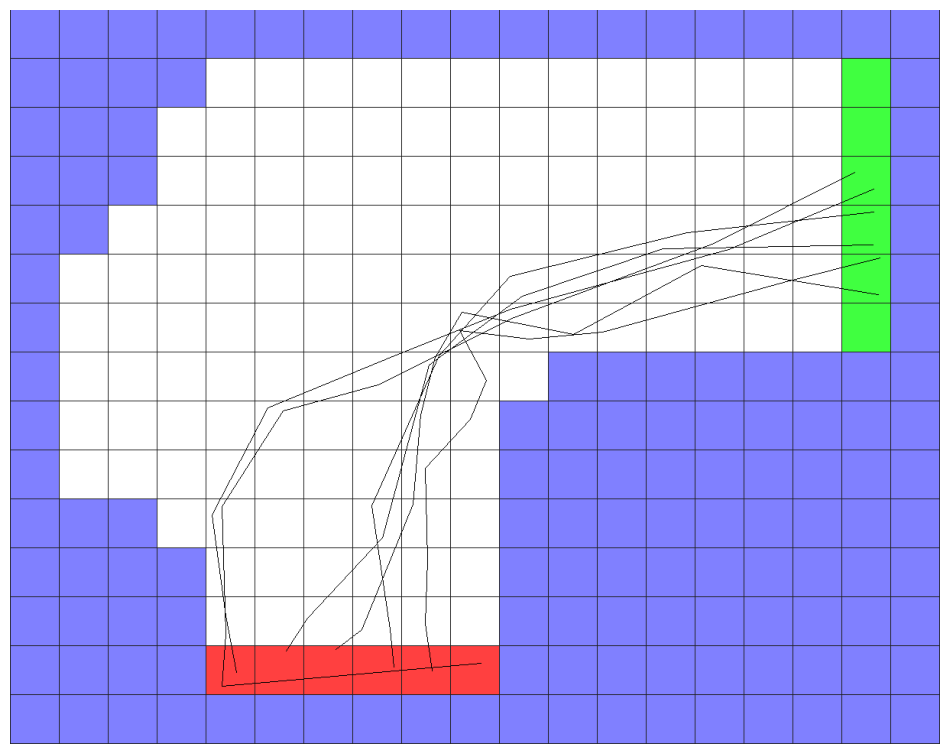

In [18]:
def estimate_optimal_policy__mcts(problem, select_cnt, discount_factor, epsilon_greedy, max_episodes, max_episode_steps):

    q_values = dict()     # state -> array of Q values: [Q(state, action 0), ..., Q(state, action 8)]
    cnt_visits = dict()   # state -> number of visits for each action: [N(s,0), N(s,1), ..., N(s,8)]

    def __get_action_epsilon_greedy(env: RacetrackEnv):
        state = env.state
        posrow, poscol, velrow, velcol = state
        is_random_action = (np.random.rand() <= epsilon_greedy) or (state not in q_values)

        while True:
            if is_random_action:
                action_idx = np.random.randint(0, 9)
            else:
                action_idx = np.argmax(q_values[state])

            incorrect, reset_position, finish = problem.check_move(posrow, poscol, velrow, velcol, action_idx)
            if not incorrect:
                return action_idx

    def __get_rollout_action(env: RacetrackEnv):
        posrow, poscol, velrow, velcol = env.state
        while True:
            action_idx = np.random.randint(0, 9)
            incorrect, reset_position, finish = problem.check_move(posrow, poscol, velrow, velcol, action_idx)
            if not incorrect:
                return action_idx

    def __select(tree_nodes: set, root_env: RacetrackEnv):
        leaf_env = root_env
        sar_array = [root_env]    # selected path [env0, action0, reward1, env1, action1, reward2, ...],
        done = False

        while sar_array[-1].state in tree_nodes:
            leaf_env = sar_array[-1].copy(with_log=False)

            action_idx = __get_action_epsilon_greedy(leaf_env)
            state, reward, done = leaf_env.step(action_idx)

            sar_array.append(action_idx)
            sar_array.append(reward)
            sar_array.append(leaf_env)
            if done:
                break

        return sar_array, done

    def __expand(sar_array):
        env_copy = sar_array[-1].copy(with_log=False)

        action_idx = __get_rollout_action(env_copy)
        state, reward, done = env_copy.step(action_idx)

        sar_array.append(action_idx)
        sar_array.append(reward)
        sar_array.append(env_copy)
        return sar_array, done

    def __simulate(env: RacetrackEnv):
        env = env.copy(with_log=False)
        G = 0
        gamma = 1

        while True:
            action_idx = __get_rollout_action(env)
            next_state, reward, done = env.step(action_idx)
            gamma *= discount_factor
            G += gamma * reward
            if done:
                break

        return G

    def __backpropagate(sar_array, G):
        # G - estimation of the rollout path starting from state sar_array[-1], or zero if that state is terminal
        assert len(sar_array) % 3 == 1

        for sar_i in range(len(sar_array) // 3 - 1, -1, -1):
            env, action_idx, reward = sar_array[3 * sar_i], sar_array[3 * sar_i + 1], sar_array[3 * sar_i + 2]
            state = env.state

            if state not in q_values:
                q_values[state] = np.ones(9) * (-np.inf)
                cnt_visits[state] = np.zeros(9)

            G = reward + discount_factor * G

            curr_q_values = q_values[state]
            curr_cnt_visits = cnt_visits[state]

            if curr_cnt_visits[action_idx] == 0:   # First visit, need to change from -inf to zero
                curr_q_values[action_idx] = 0

            curr_cnt_visits[action_idx] += 1
            curr_q_values[action_idx] += (G - curr_q_values[action_idx]) / curr_cnt_visits[action_idx]

    def __mcts(env: RacetrackEnv):
        tree_nodes = set()

        for _ in range(select_cnt):

            sar_array, done = __select(tree_nodes, env)

            tree_nodes.add(sar_array[-1].state)

            G = 0
            if not done:
                sar_array, done = __expand(sar_array)

                if not done:
                    G = __simulate(sar_array[-1])

            __backpropagate(sar_array, G)

        return np.argmax(q_values[env.state])

    def __convert_q_to_policy():
        policy = problem.create_trivial_policy('uniform')
        for state, q_s in q_values.items():
            posrow, poscol, velrow, velcol = state

            policy[posrow, poscol, velrow, velcol, :] = 0
            policy[posrow, poscol, velrow, velcol, np.argmax(q_s)] = 1

        return policy

    train_curves = defaultdict(list)
    for episode in range(max_episodes):

        env = RacetrackEnv(problem, start_pos_idx=None, max_episode_steps=max_episode_steps, need_log=False)
        env.reset()

        episode_steps = 0
        episode_reward = 0

        while True:
            action_idx = __mcts(env)
            next_state, reward, done = env.step(action_idx)

            episode_reward += reward
            episode_steps += 1

            if done:
                break

        train_curves['Steps per episode'].append(episode_steps)
        train_curves['Train episode rewards'].append(episode_reward)

        policy = __convert_q_to_policy()
        run = problem.generate_run_using_policy(policy, max_episode_steps=max_episode_steps, start_pos_idx=None, need_log=True)
        train_curves['Policy eval rewards'].append(run.get_total_reward())

    policy = __convert_q_to_policy()
    return policy, train_curves

def solve_mcts(mode, max_velocity, max_episodes, max_episode_steps):
    problem = Racetrack(mode=mode, max_velocity=max_velocity)
    policy, train_curves = estimate_optimal_policy__mcts(problem, select_cnt=10, discount_factor=0.99, epsilon_greedy=0.1, max_episodes=max_episodes, max_episode_steps=max_episode_steps)

    runs = []
    total_reward = 0
    for start_pos_idx in range(len(problem.start_positions)):
        run = problem.generate_run_using_policy(policy, max_episode_steps=100, start_pos_idx=start_pos_idx, need_log=True)
        runs.append(run)
        total_reward += run.get_total_reward()
    problem.render(runs)
    print("total reward", total_reward)

solve_mcts('medium', max_velocity=5, max_episodes=100, max_episode_steps=30)

total reward 298


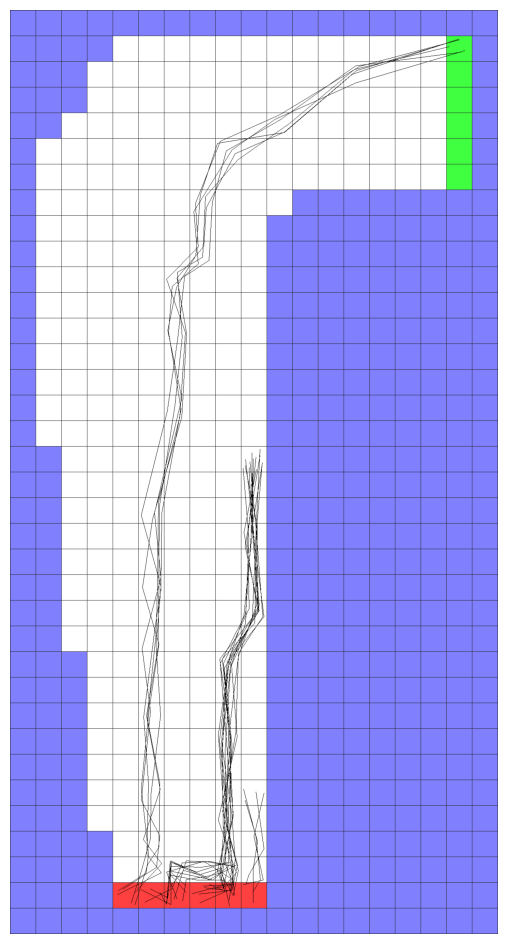

In [19]:
solve_mcts('hard', max_velocity=5, max_episodes=100, max_episode_steps=30)

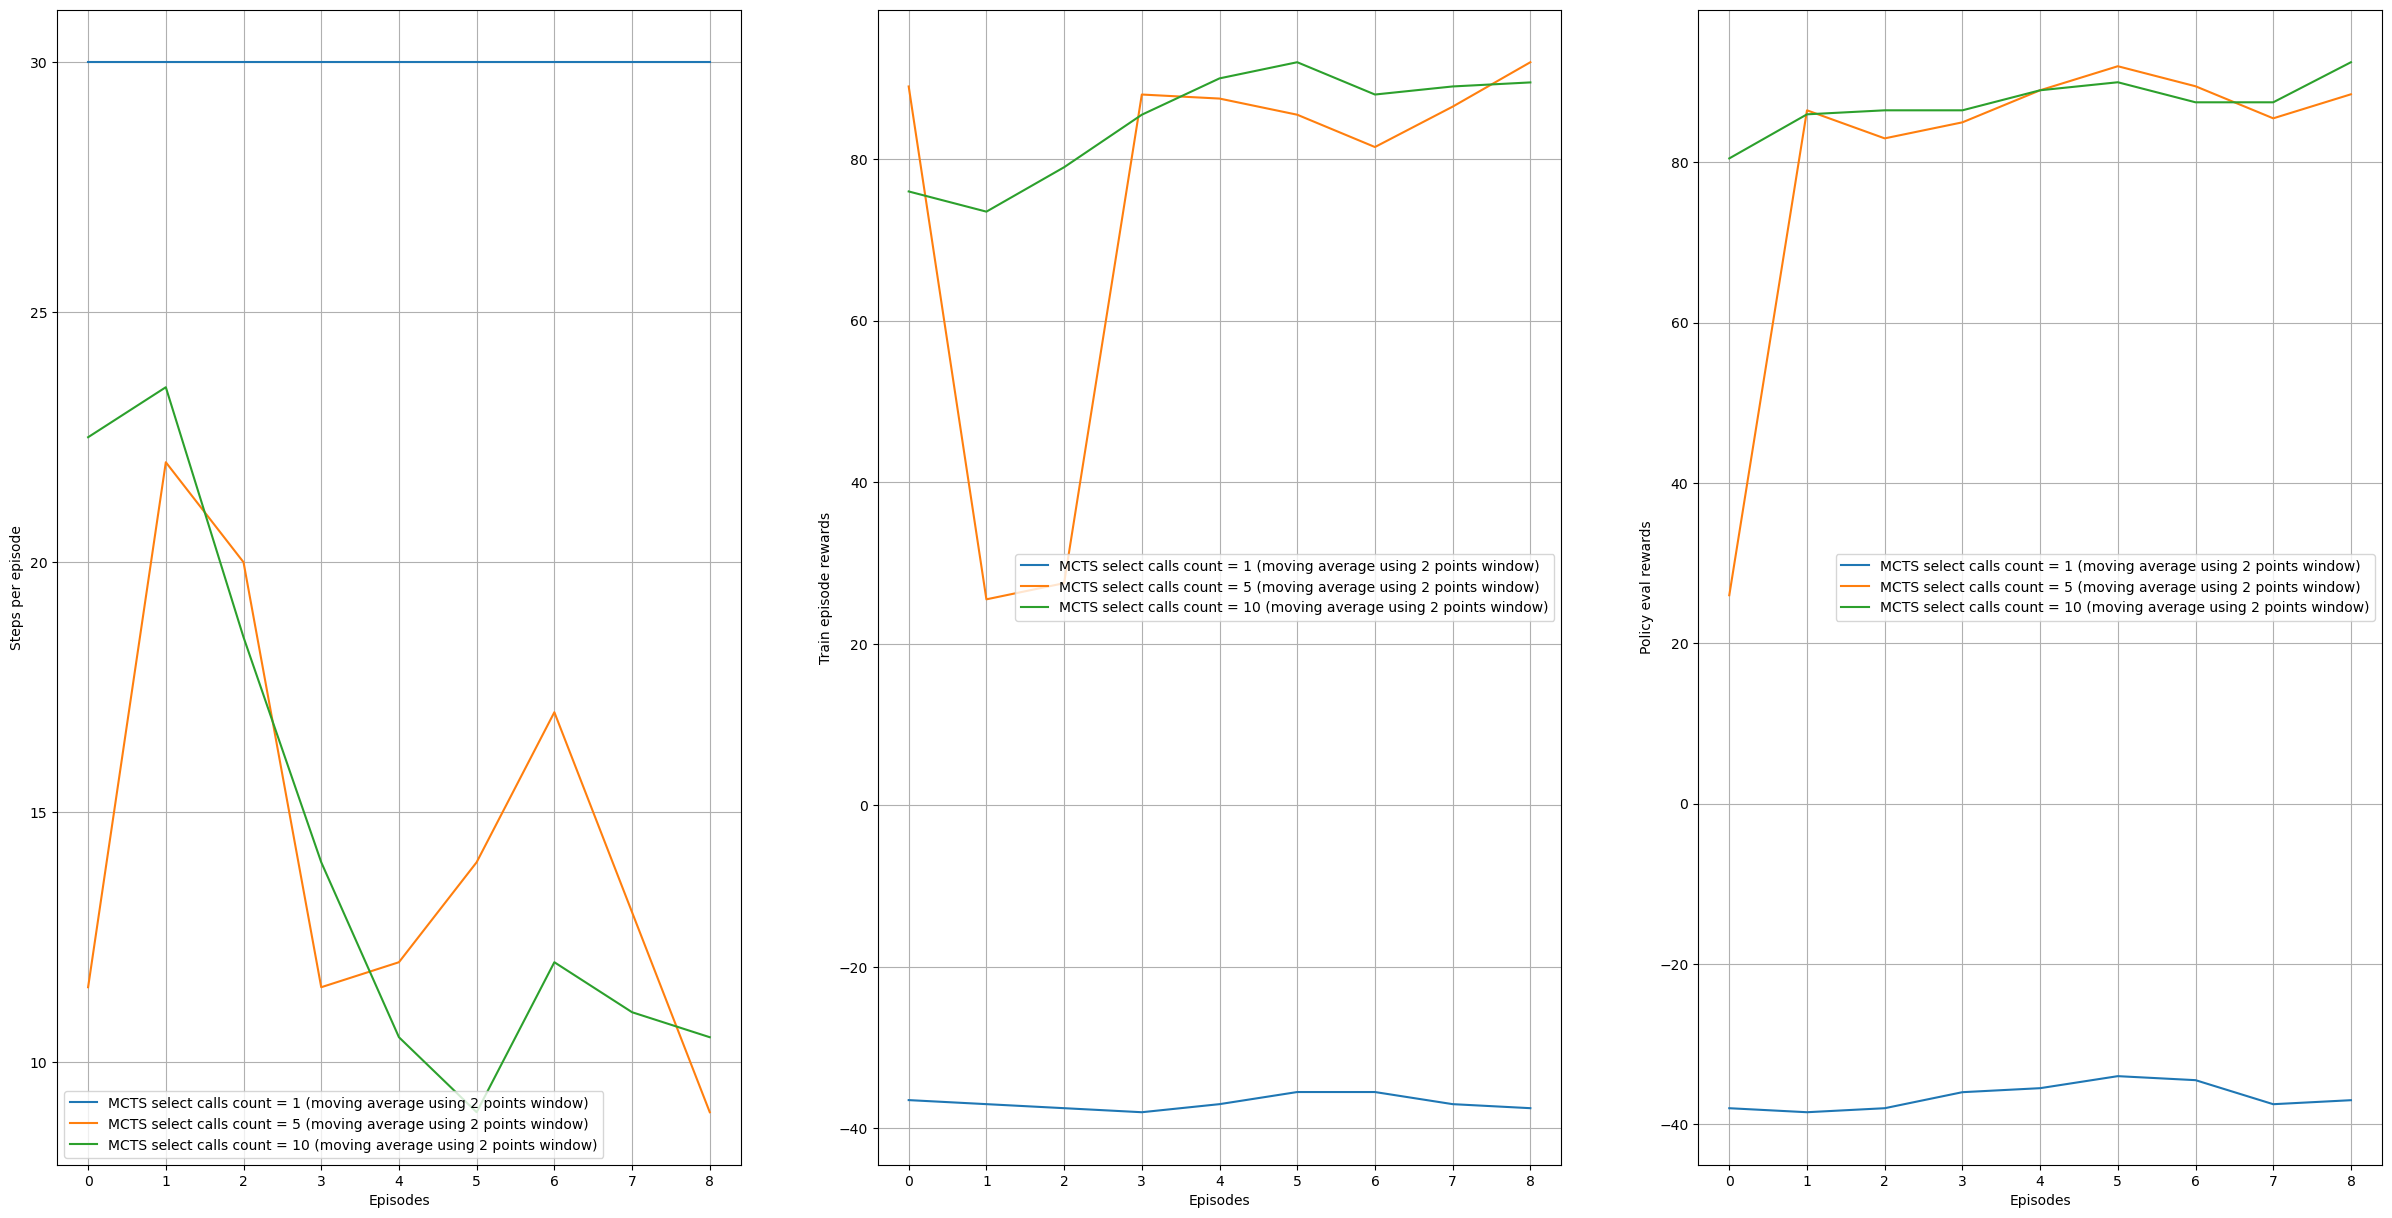

In [20]:
def show_mcts_curves(mode, max_velocity, max_episodes):
    problem = Racetrack(mode=mode, max_velocity=max_velocity)

    grouped_train_curves = dict()

    for select_cnt in [1, 5, 10]:
        policy, train_curves = estimate_optimal_policy__mcts(problem, select_cnt=select_cnt, discount_factor=0.99, epsilon_greedy=0.1, max_episodes=max_episodes, max_episode_steps=30)

        grouped_train_curves[select_cnt] = train_curves

    curves_labels = list(train_curves.keys())

    fig, ax = plt.subplots(nrows=1, ncols=len(curves_labels))
    fig.set_size_inches(30, 15)

    for ci, curve_label in enumerate(curves_labels):
        for select_cnt in grouped_train_curves.keys():
            points = grouped_train_curves[select_cnt][curve_label]

            N = max(2, len(points) // 50)
            cumsum = np.cumsum(np.insert(points, 0, 0))
            moving_average = (cumsum[N:] - cumsum[:-N]) / float(N)

            ax[ci].plot(np.arange(len(moving_average)), moving_average, label=f"MCTS select calls count = {select_cnt} (moving average using {N} points window)")

        ax[ci].set_xlabel("Episodes")
        ax[ci].set_ylabel(curve_label)
        ax[ci].legend()
        ax[ci].grid(True)

show_mcts_curves('medium', max_velocity=5, max_episodes=10)

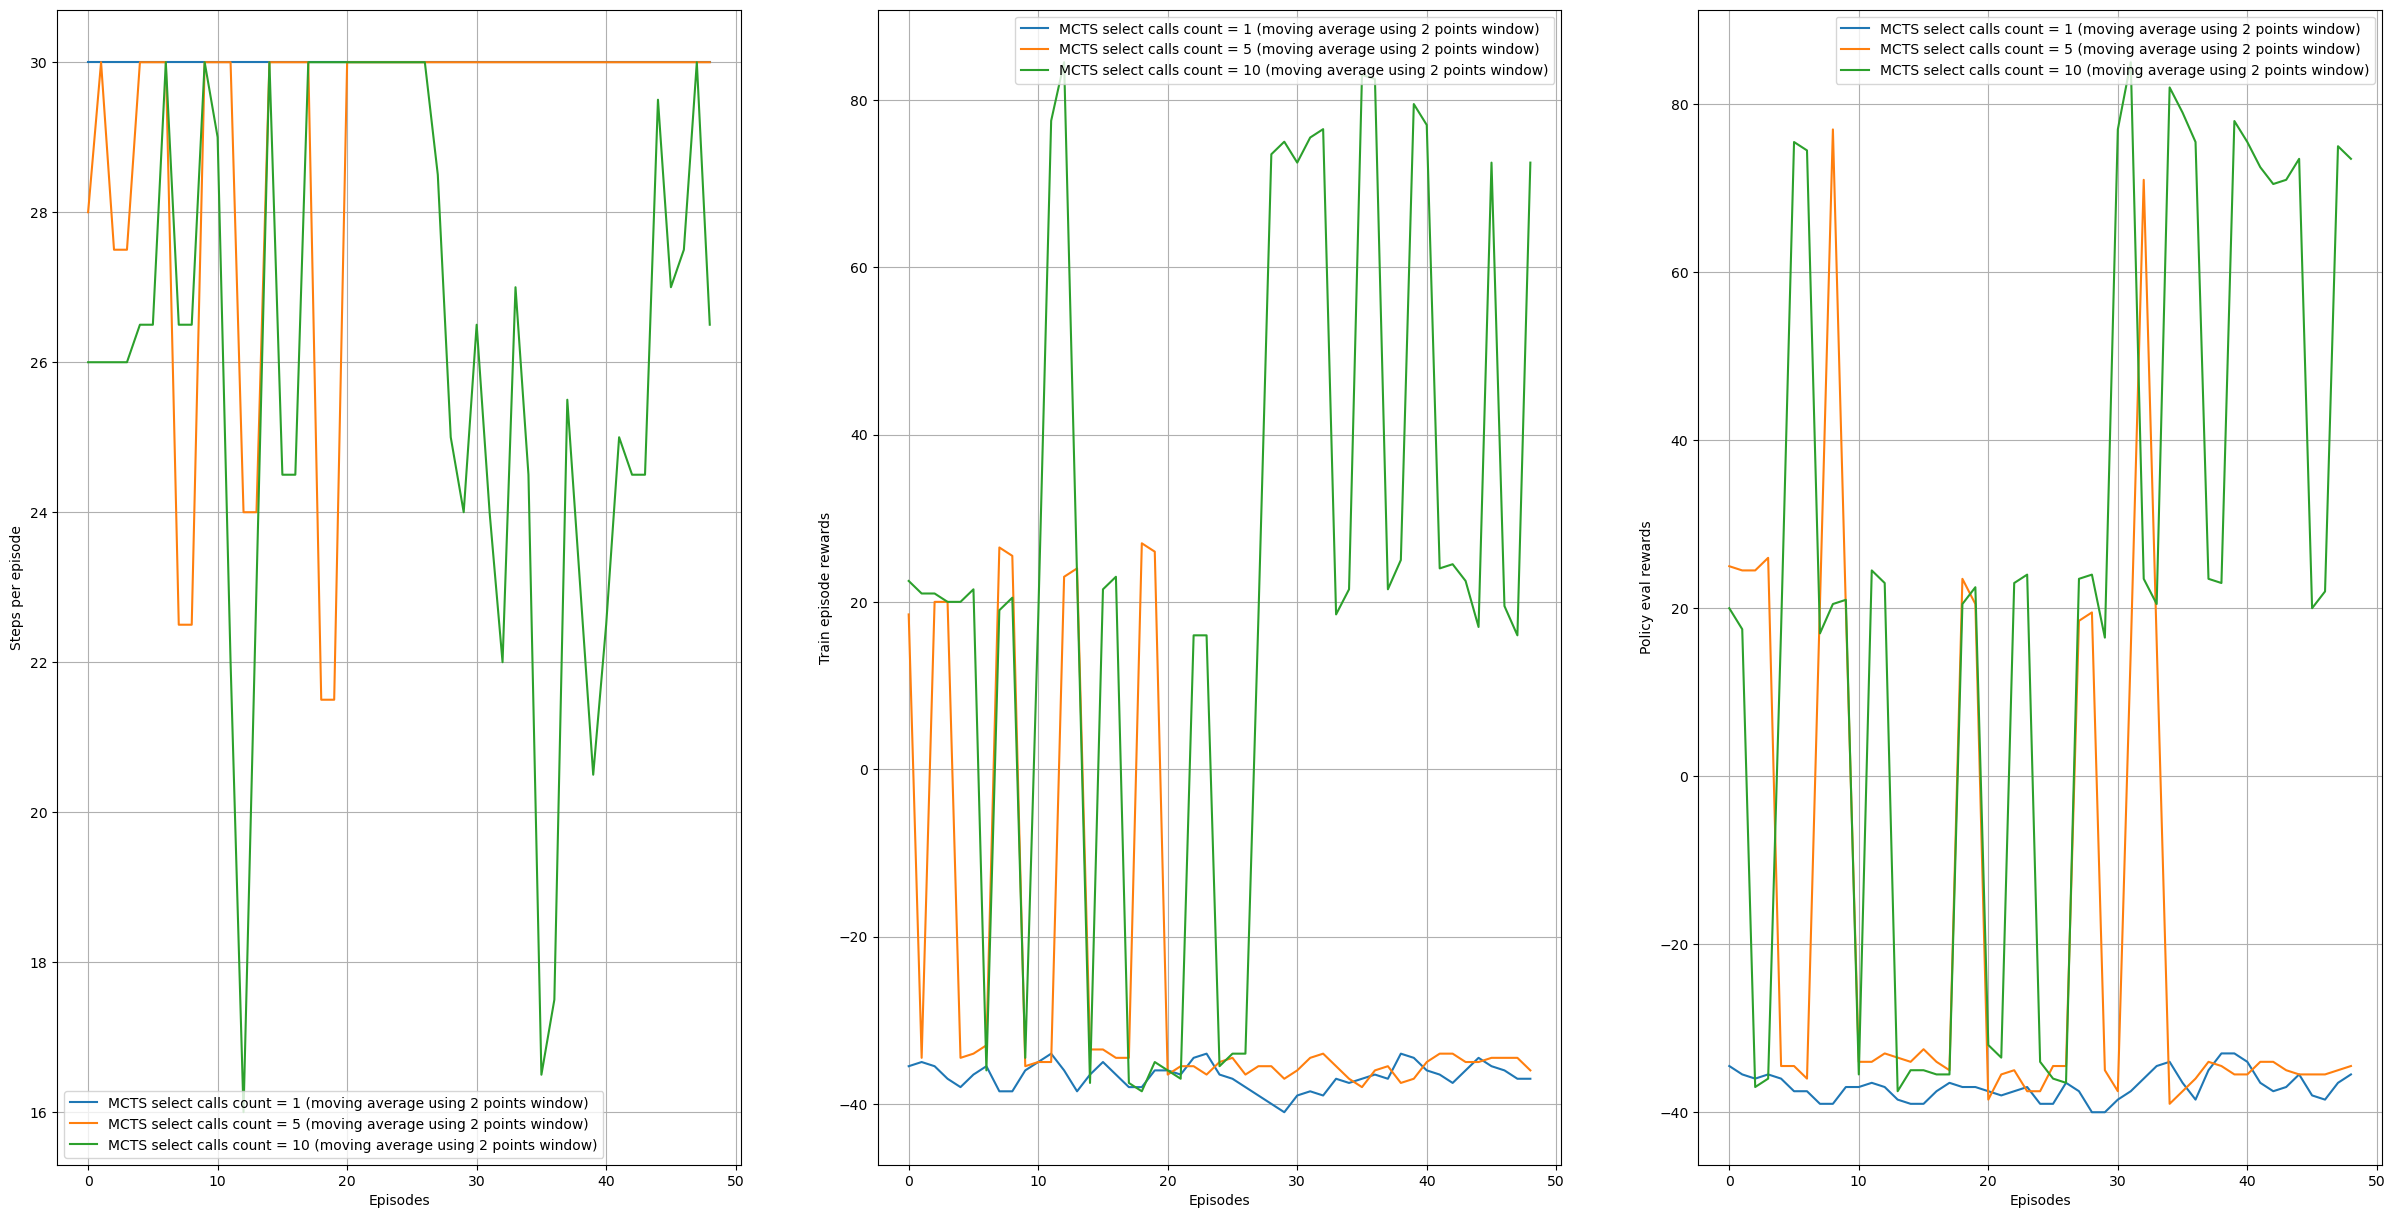

In [21]:
show_mcts_curves('hard', max_velocity=5, max_episodes=50)